In [1]:
from classes_V3 import *

In [2]:
d = DC_IV('hBN_1')

In [3]:
d.delete_measurs(16, [i for i in range(52)] + [i for i in range(101,107)] + [154,155])
I = d.get_on_off_current(16, 1)

(<Figure size 1200x700 with 9 Axes>,
 <Axes: >,
 [<Axes: >, <Axes: >, <Axes: >, <Axes: >],
 [<Axes: >, <Axes: >, <Axes: >, <Axes: >])

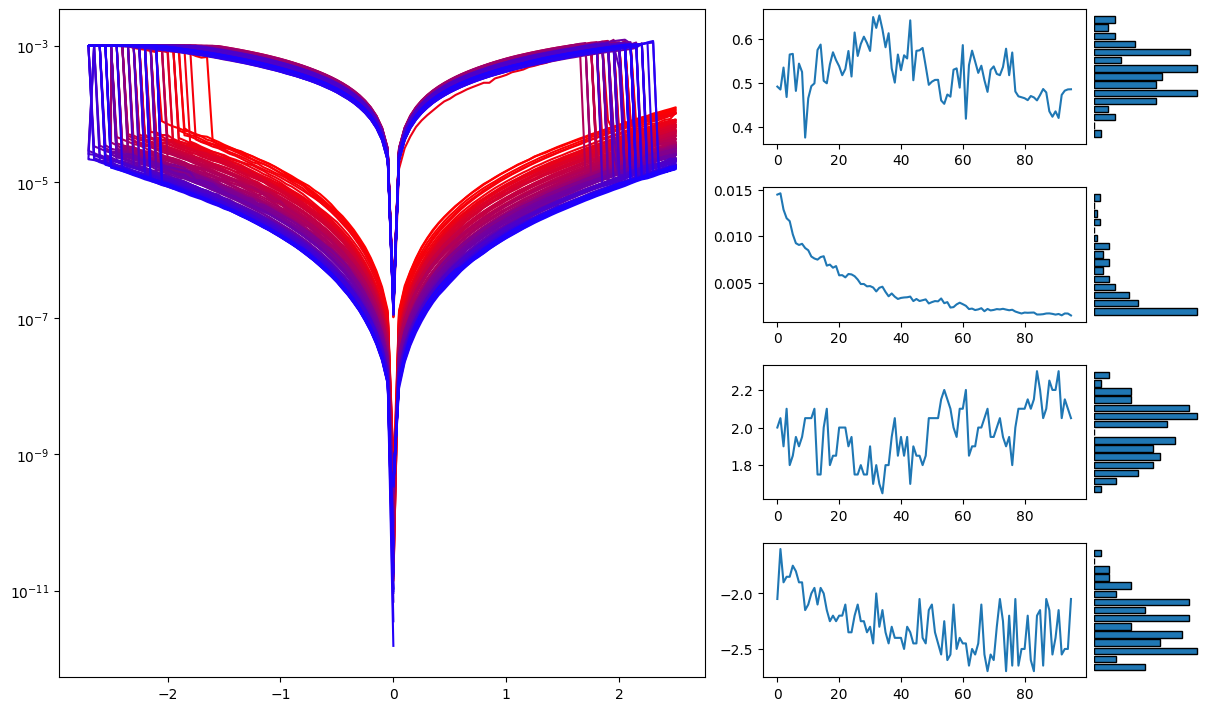

In [5]:
d.draw_full_ReRAM_info(16, 1, bins=15)